**Importing libraries and loading the dataset**
***

In [1]:
import pandas as pd
from numpy import nan

# ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ply

# Set matplot lib style profile to the default one
plt.style.use('default')

data = pd.read_csv('Leadzai_DS_r&s_Exercise01_netflix.csv')
data.head(4)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."


In [2]:
# Checking columns with nan's and their percentage relative to the dataset.
data.isna().sum()[data.isna().sum()>0]/data.shape[0]*100

director      29.908028
cast           9.367549
country        9.435676
date_added     0.113546
rating         0.045418
duration       0.034064
dtype: float64

**Understanding the columns meaning and significance**
***
+ Show_id: Unique identifier of the show, not useful for our analysis.
+ Type: Can be either a movie or a TV Show. We will split our dataset on this class as it makes sense to analyse them individually.
+ Title: Another unique identifier, we won't use it as a target for analysis.
+ Director: roughly 30% of the values are not known, we can either leave them be and not take them into account or we can assign them to Unknown
+ Cast: Same situation as the director, with a 10% not known values
+ Country: This column is very interesting as it instructs us about the movie provenance, since there are some multi-country rows we will either encode it into single columns or analyse the multi-country ones and group them in some fashion 
+ Date_added: Release date on NetFlix, will be decomposed into month, year and perhaps week of the year to analyse release density.
+ Release_year: We will use this column to analyse if our content is up to date or if our library is on the old side.
+ Rating: Show/movie rating, We can conduct a rating analysis on this field and see what’re our top and bottom categories.
+ Duration: Contains as the name implies the duration of movies and shows, We will find out what the ideal movie/show length is based on rating.
+ Listed_id: This stores the categories associated with a show/movie, and will be expanded to encoded columns since most of them have multi-class
+ Description: This is just a description, some sort of NLP could be done to research the impact of a good description into a movie/show performance, but since we don't have the performance data for each show nothing will be done here, it's a drop like show_id.

<br>

**Actions list.**
***
- Drop show_id and description
- Fill nan's in director and cast to unknowns.
- Create a column with the number of countries calculated from country. I'll decide later if it will be encoded or not.
- Decompose date added into month, year and week.
- Duration, get rid of min and seasons.
- Encode listed_in category column.



In [3]:
# droping columns
data = data.drop(columns=['show_id','description'])

In [4]:
# filling nan's
data.director.fillna('Unknown', inplace=True)
data.cast.fillna('Unknown', inplace=True)

In [5]:
# function to sum all values passed
def count_row_val(row):
    return sum(row)

# creating a column with the number of countries of provenance
data['n_countries'] = data.country.str.get_dummies(sep=', ').apply(count_row_val, axis=1)

In [6]:
# converting date to date format and adding new time related columns. using the iso calendar new method as se simple dt.week eg is going to be deprecated in future versions.
data.date_added = pd.to_datetime(data.date_added)
data['added_week'] = data.date_added.dt.isocalendar().week
data['added_month'] = data.date_added.dt.month
data['added_year'] = data.date_added.dt.isocalendar().year

# Calculating the diference between release of the movie/tv show and the actual release on the platform 
data['year_diferencial'] = data.added_year-data.release_year

In [7]:
# Expanding the listed_in ceategories column
data = pd.concat([data, data.listed_in.str.get_dummies(sep=', ')], axis = 1)

In [8]:
# splitting the data
movies = data[data.type == 'Movie']
shows = data[data.type == 'TV Show']

In [9]:
# function to split a string by "space" and return the first element
def split_seasons(x):
    return x.split(' ')[0]

In [ ]:
# Cleaning the duration into minutes for movies and seasons for TV shows
movies.duration = pd.to_numeric(movies.duration.str.replace(' min', ''))
shows.duration = pd.to_numeric(shows.duration.apply(split_seasons))

**EDA**
***
I'll plot some columns and relations I found interesting and analysis worthy.

**Movie an TV show duration. Let's check the more usual distributions.**

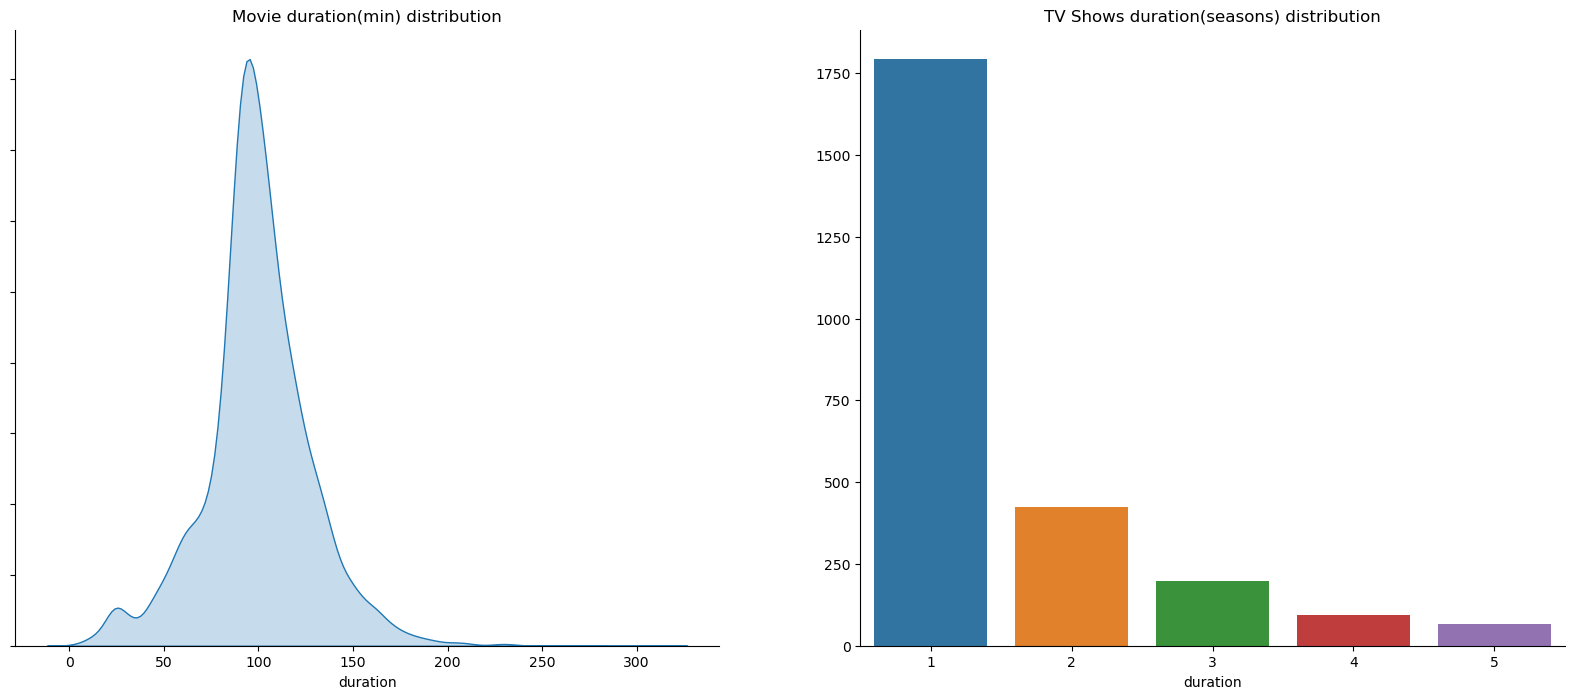

In [11]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

sns.kdeplot(ax=axs[0], data=movies.duration, fill = True)
axs[0].set_title('Movie duration(min) distribution')
axs[0].set(ylabel=None, yticklabels=[])
sns.countplot(ax=axs[1], data=shows[shows.duration<6], x = 'duration')
axs[1].set_title('TV Shows duration(seasons) distribution')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

<br>

- We can see that regarding movies the overall distribution tells us that the usual duration is between 60 to 140 minutes, peaking at 100 minutes. Movies outside that interval tend to be a small number of outliers.
<br>

- Regarding TV shows we can see a high amount of a single-season shows, the volume falls sharply at 2 seasons and becomes residual at values higher than three. This could indicate that we have many single-season series that could be either big stories that can only be told in a series or that either market analysis or quality control of many of these single series is poor. This means that many of these shows shouldn't have been produced at all or lack quality.

<br>

Further exploring movies, the tendency maintains across all ratings, changing a bit in some specific categories like TV-Y which is meant for younger spectators that is denser in the 20 minutes duration, which is due to a youngster’s attention span. Some categories like 74min, 66min and 84min are categories that just have one movie, so they are not to be taken into account.

In [ ]:
# Rerun for interactive plot interaction
fig = ply.histogram(movies[~movies.rating.isna()], x='duration', color='rating', width=1600, height=800, labels={"duration": "Duration"})
fig.update_layout(title_text='Movie duration(min) distribution')
fig.show()

![Interactiveplot1](Plot1.png)

Looking again at TV Shows, we can see that most rating categories follow the same pattern but some have higher ratios of season 2 density and above, again TV-Y and TV-Y7 for youngsters.

In [ ]:
# Rerun for interactive plot interaction
fig = ply.histogram(shows[~shows.rating.isna()], x='duration', color='rating', width=1600, height=800, labels={"duration": "Duration"})
fig.update_layout(title_text='Shows duration(min) distribution')
fig.show()

![Interactiveplot1](Plot2.png)

***
Not every rating is represented in the TV Shows data, as stated in the pivot table below.
Expanding TV shows with R, PG-13 and PG ratings could prove successful.

In [14]:
data.pivot_table(index=['rating'], columns=['type'], dropna=False, aggfunc={'type':'count'}).fillna(0)

type        
type       Movie TV Show
rating                  
66 min       1.0     0.0
74 min       1.0     0.0
84 min       1.0     0.0
G           41.0     0.0
NC-17        3.0     0.0
NR          75.0     5.0
PG         287.0     0.0
PG-13      490.0     0.0
R          797.0     2.0
TV-14     1427.0   733.0
TV-G       126.0    94.0
TV-MA     2062.0  1145.0
TV-PG      540.0   323.0
TV-Y       131.0   176.0
TV-Y7      139.0   195.0
TV-Y7-FV     5.0     1.0
UR           3.0     0.0

**Portfolio Diversity**
***
Let's check and compare the mix of the top categories of titles both in movies and TV Shows

In [15]:
# helper function to unpack a multi-value column of categories into encoded one
def get_exploded_df(data):
    tmp = pd.DataFrame(data.listed_in.str.get_dummies(sep=', ').sum()).reset_index()
    tmp.columns = ['category','val']
    return tmp.sort_values(by='val', ascending=False)

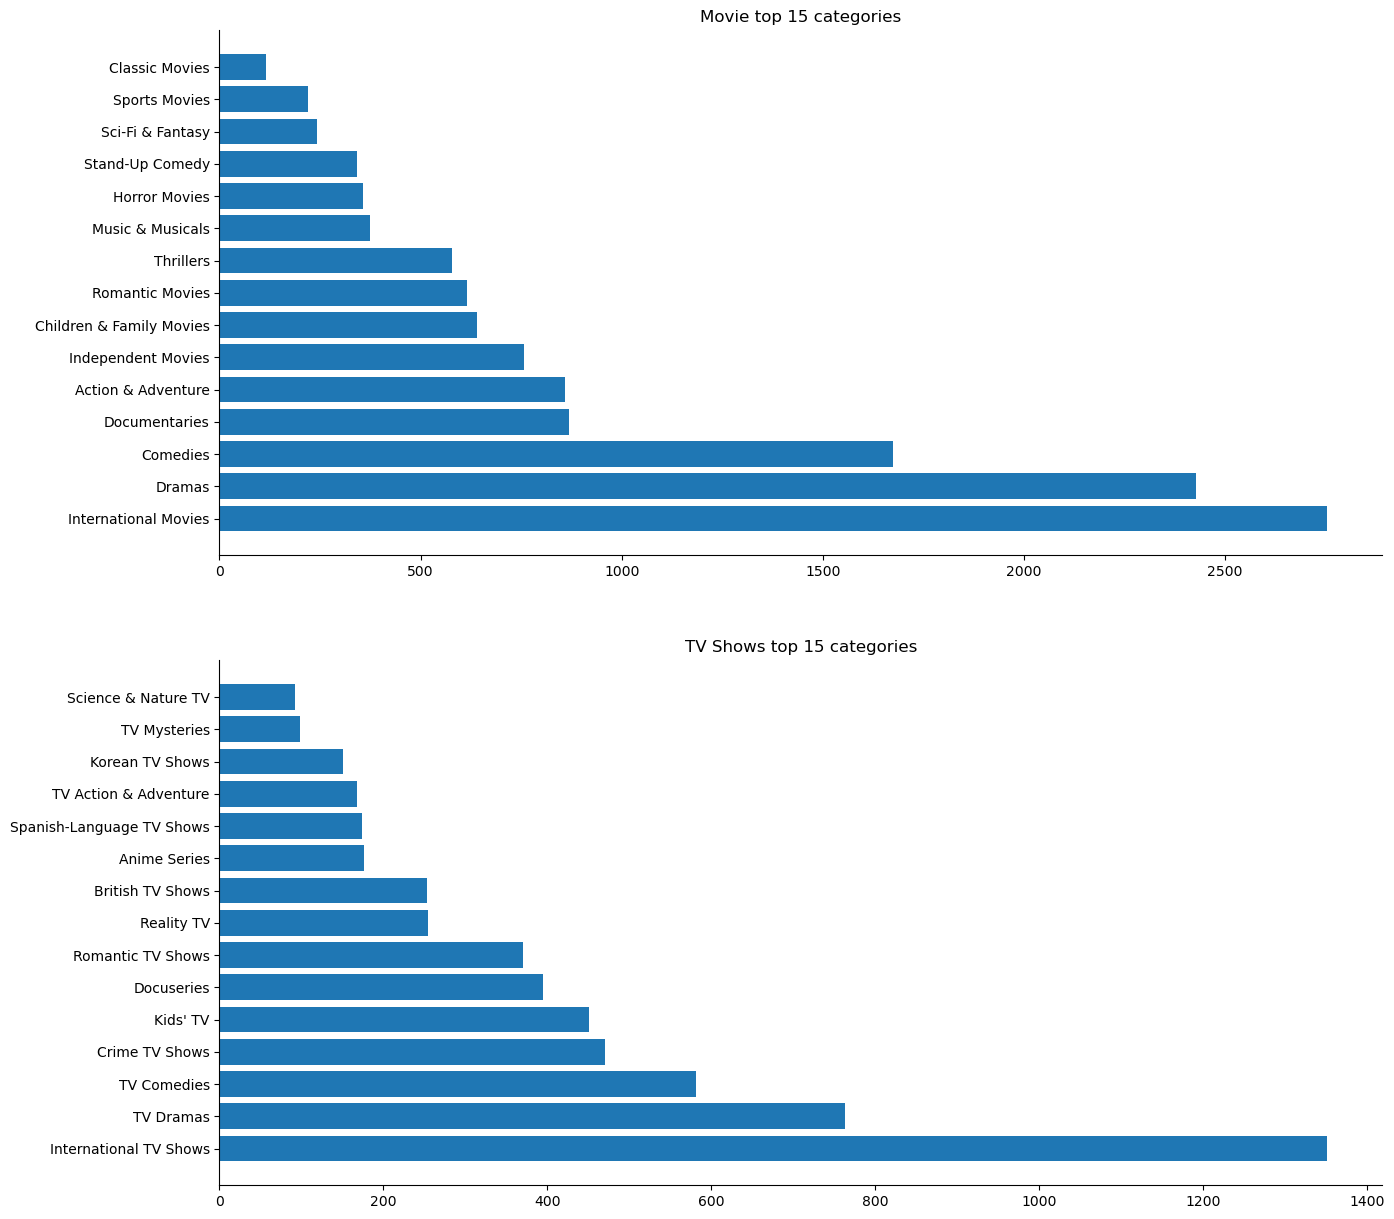

In [16]:
movies_cats = get_exploded_df(movies).head(15)
shows_cats = get_exploded_df(shows).head(15)

fig, axs = plt.subplots(2,1, figsize=(15,15))

axs[0].barh(movies_cats['category'],movies_cats['val'])
axs[0].set_title('Movie top 15 categories')
axs[1].barh(shows_cats['category'],shows_cats['val'])
axs[1].set_title('TV Shows top 15 categories')

sns.despine()
plt.show()

We can see that the top 3 in both categories have the same same order, although from there the composition and order are very diferent.

**Let's now analyse the top 20 country of origin for movies and TV shows**
***

In [17]:
# Unpacking the column because we have many rows that have multi countries of origin.
def unpack_country(data):
    bycountry = pd.DataFrame(data.country.str.get_dummies(sep=', ').sum()).reset_index()
    bycountry.columns = ['country','value']
    bycountry.sort_values(by='value', ascending=False, inplace=True)
    return bycountry[:20]

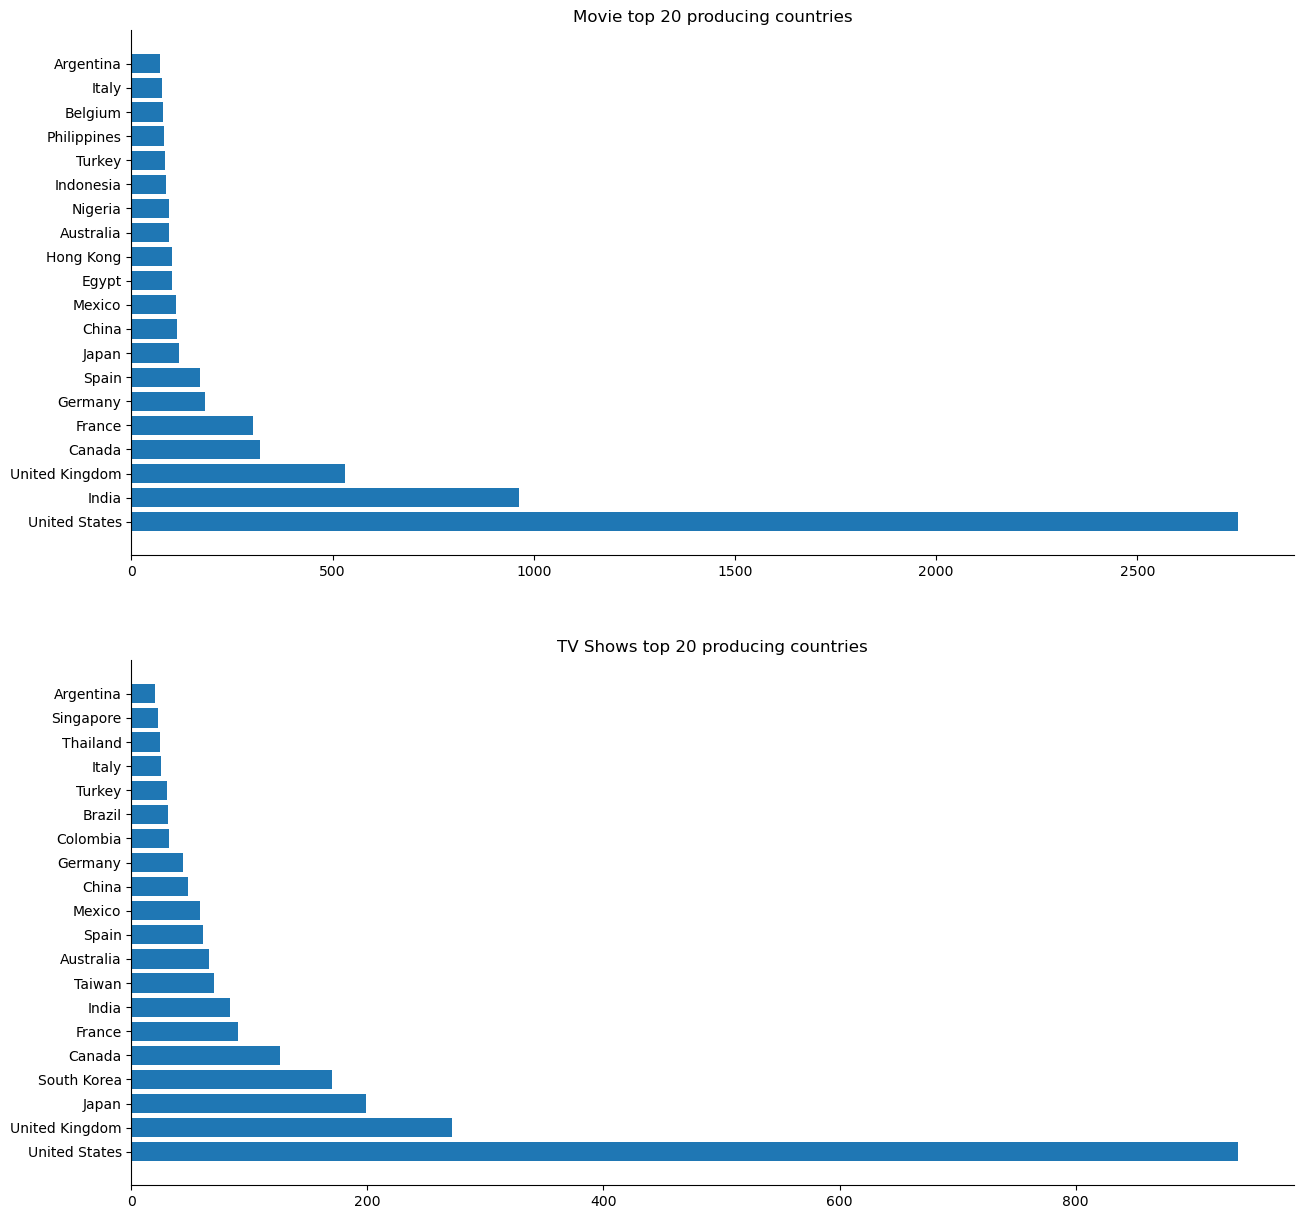

In [18]:
# Getting the top20 countries for each category. This has to be made because as stated above some rows
# have more than one country, but all is in a text string
top20_movies = unpack_country(movies)
top20_shows = unpack_country(shows)

fig, axs = plt.subplots(2,1, figsize=(15,15))

axs[0].barh(top20_movies['country'],top20_movies['value'])
axs[0].set_title('Movie top 20 producing countries')
axs[1].barh(top20_shows['country'],top20_shows['value'])
axs[1].set_title('TV Shows top 20 producing countries')

sns.despine()
plt.show()

**Main takeaways regarding country of origin**
***
- The United States are the leading country in both categories, but we can see different players below for each category.
- India, as we know India is a powerhouse globally with their Bollywood industry and that shows in the movie plot, where they are a strong 2nd contender with almost the double the 3rd(UK), in the TV Shows it drops a lot. 
- Uk is globally the second player, but more relevant on the TV shows.
- Japan and South Korea are not relevant regarding movies, the latter doesn't even show in our movies’ top 20, but they come really strong in the TV Show section.
- Canada and France are also strong players in both sections.
- Other countries represent a really small portion of the NetFlix library.

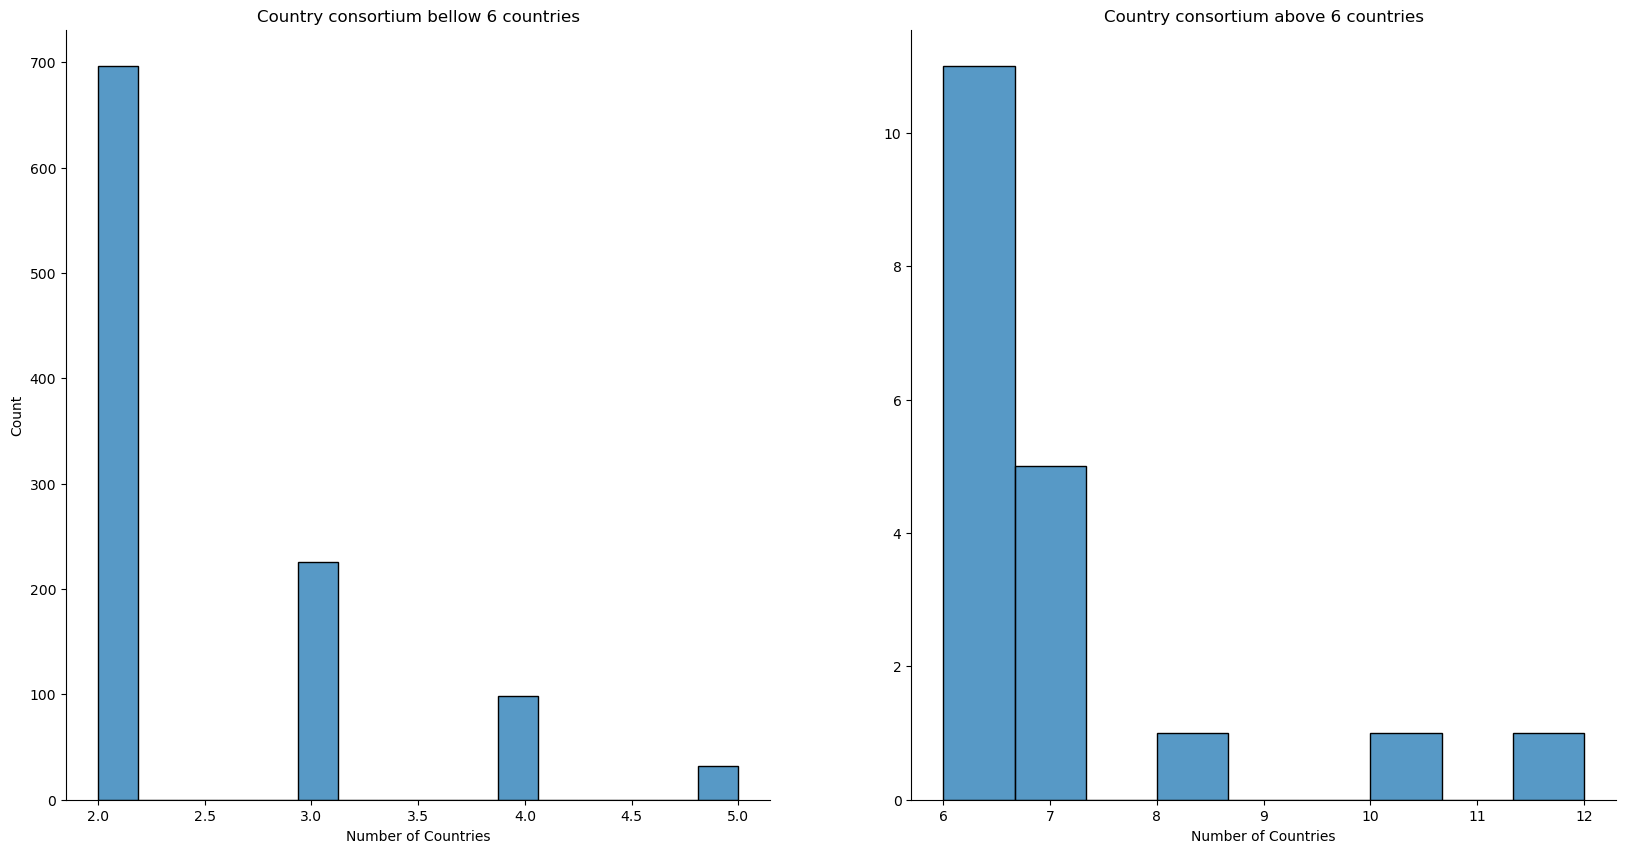

In [19]:
#Looking into multi-country titles from the whole dataset
fig, axs = plt.subplots(1,2, figsize=(20,10))

sns.histplot(ax=axs[0], data=movies.query('n_countries  < 6 & n_countries  > 1')['n_countries'])
axs[0].set_title('Country consortium bellow 6 countries')
axs[0].set(xlabel='Number of Countries')
axs[0].set(ylabel='Count')
sns.histplot(ax=axs[1], data=movies.n_countries[movies.n_countries>=6])
axs[1].set_title('Country consortium above 6 countries')
axs[1].set(xlabel='Number of Countries')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

- There´s a significant number of 2 countries joint projects, 3 and 4 countries in the same project is also relevant.
- From 5 onwards it's not meaningful, the second plot zooms into that, and as is possible to see it's completely negligible.

**Release dates analysis**
***
As a last step, we will see if we have any sort of delay in releasing movies and shows, as well as the release dates on the platform.

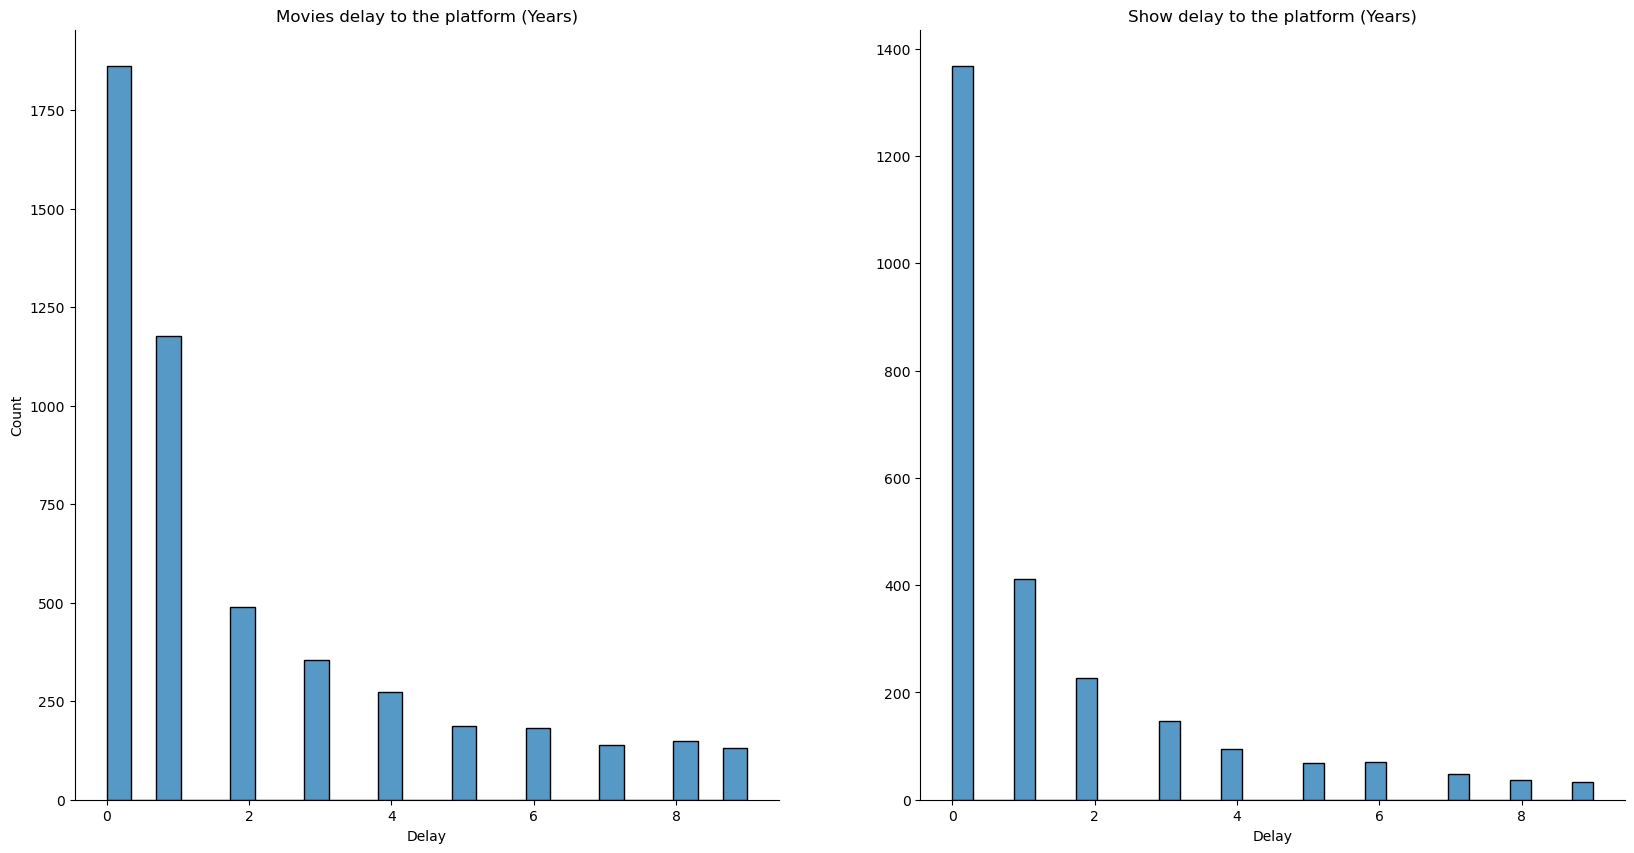

In [20]:
#Looking into multi-country titles from the whole dataset
fig, axs = plt.subplots(1,2, figsize=(20,10))

sns.histplot(ax = axs[0], data = movies[(movies.year_diferencial < 10) & (movies.year_diferencial >= 0)]['year_diferencial'])
axs[0].set_title('Movies delay to the platform (Years)')
axs[0].set(xlabel='Delay')
axs[0].set(ylabel='Count')
sns.histplot(ax = axs[1], data = shows[(shows.year_diferencial < 10) & (shows.year_diferencial >= 0)]['year_diferencial'])
axs[1].set_title('Show delay to the platform (Years)')
axs[1].set(xlabel='Delay')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

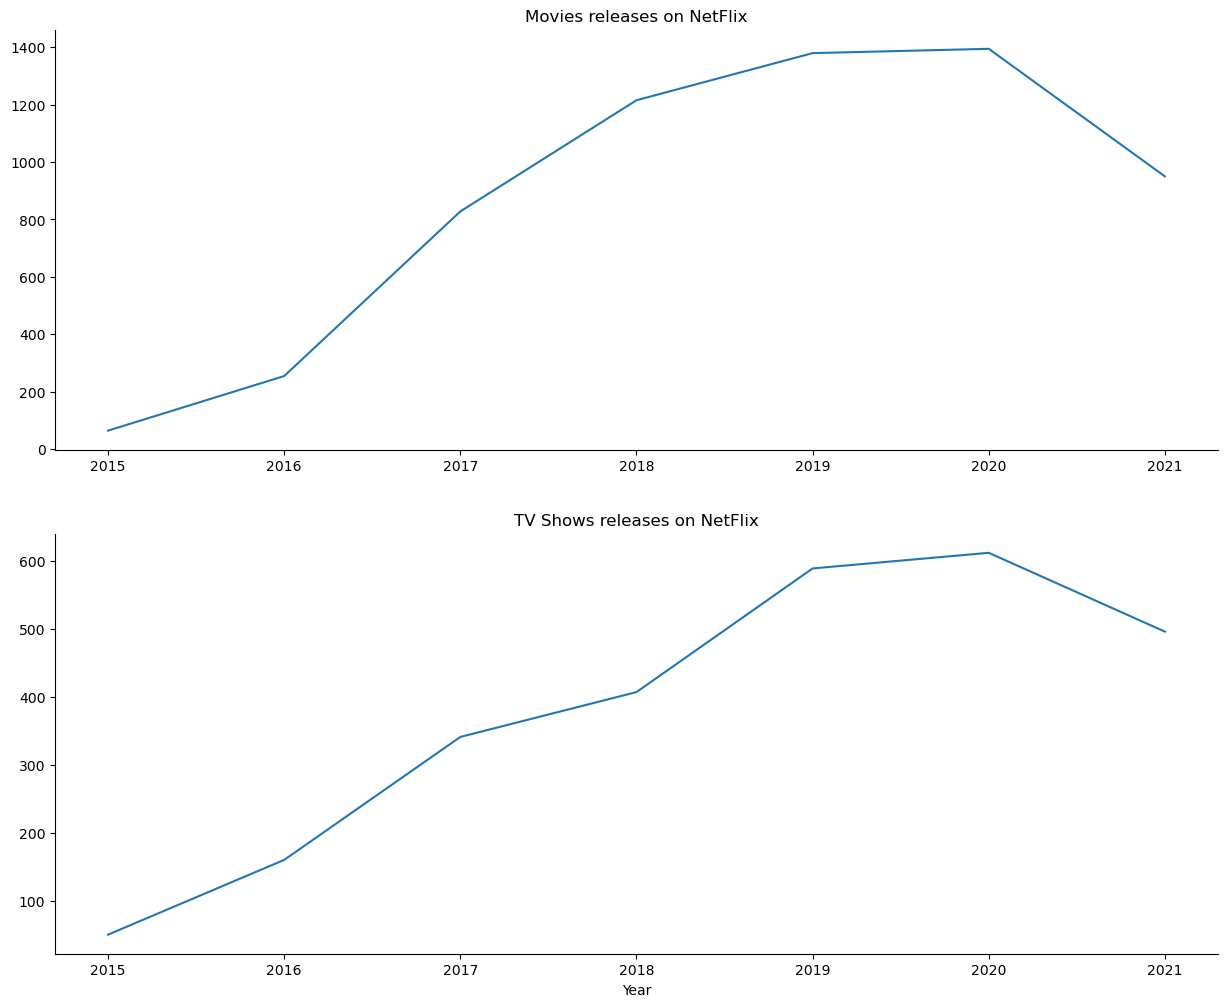

In [21]:
# Ploting releases on the platform for comparisson
fig, axs = plt.subplots(2,1, figsize=(15,12))

axs[0].plot(movies[movies.added_year>2014].groupby(by='added_year', dropna=True).agg({'added_year':'count'}))
axs[0].set_title('Movies releases on NetFlix')
axs[0].set(xlabel=None)
axs[0].set(ylabel=None)
axs[1].plot(shows[shows.added_year>2014].groupby(by='added_year', dropna=True).agg({'added_year':'count'}))
axs[1].set_title('TV Shows releases on NetFlix')
axs[1].set(xlabel='Year')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

**Main takeaways on releases**
***
<br>

- We can see clearly that the number of releases until 2018 for movies was very good and scaled linearly, and then it stabilized until 2020. 
- For TV shows the global tendency was pretty much the same but it scaled really well until 2019, maintaining 2019 release numbers in 2020.
- 2021 saw a big drop in releases, to values somewhere between 2017-2018
- Releases for movies are more delayed than TV Shows, by a big margin. A considerable portion of our movie releases come with a 2 to 8-year delay, turning them a bit ineffective to the platform.


**Adressing most proeminent actors in detail**
***
I'm unpacking the actors column, ignoring the Unknown ones, we can see that the top 30 is densely populated manily by Indian actors. Samuel jackson is the first of the western famous actors to appear in this list followed many places bellow by Nicolas Cage.

In [22]:
# Need to explode the data on the cast column because as before with other columns, they are all packed into a string
actors=data.cast.str.get_dummies(sep=', ')
actors = pd.DataFrame(actors.sum()).reset_index()
actors.columns = ['actor', 'count']

In [23]:
# Sorting artists by number of movies and shows
actors.sort_values(by='count', ascending=False).head(30)

,actor,count
34214,Unknown,825
2833,Anupam Kher,43
30489,Shah Rukh Khan,35
16697,Julie Tejwani,33
24215,Naseeruddin Shah,32
32591,Takahiro Sakurai,32
28974,Rupa Bhimani,31
25424,Om Puri,30
846,Akshay Kumar,30
35881,Yuki Kaji,29


**Let's explore our more proeminent actors**
***
I'll make a test with our top actor, Anupam Kher and then I'll make a full dictionary with some important atributes and put them into a dataframe.

In [24]:
# Function to compute the details of the actor
def actor_details(actor):
    # Creating his own sub dataset
    df_actor = data[data.cast.str.contains(actor)]

    # Getting some nice stats
    top_types = list(pd.DataFrame(df_actor.listed_in.str.get_dummies(sep=', ').sum()).reset_index().sort_values(by=0, ascending=False).head(2)['index'])
    top_country = pd.DataFrame(df_actor.country.str.get_dummies(sep=', ').sum()).reset_index().sort_values(by=0, ascending=False).values[0][0]
    rating = pd.DataFrame(df_actor.rating.value_counts()).reset_index().values[0][0]

    # Building the details dictionary
    dict_actor = {'top_types': top_types,
               'top_country': top_country,
               'rating': rating}
    
    return (actor, dict_actor)

In [25]:
actor_details('Anupam Kher')

('Anupam Kher',
 {'top_types': ['International Movies', 'Dramas'],
  'top_country': 'India',
  'rating': 'TV-14'})

We can now build n top actors dictionary to have a fast access to their properties, or build a dataframe for further treatment. Our dict will allow a fast access time searching for an individual set of properties.

In [26]:
details_dict = {}

# building the dictionary of all actors details except the top one, wich is the unknown
for actor in actors.sort_values(by='count', ascending=False).head(30)['actor'][1:]:
    details = actor_details(actor)
    details_dict[details[0]] = details[1]

In [27]:
# Acessing our dictionary by key (name)
details_dict['Julie Tejwani']

{'top_types': ['Children & Family Movies', "Kids' TV"],
 'top_country': 'India',
 'rating': 'TV-Y7'}

In [28]:
pd.DataFrame(details_dict).T.head(5)

,top_types,top_country,rating
Anupam Kher,"[International Movies, Dramas]",India,TV-14
Shah Rukh Khan,"[International Movies, Dramas]",India,TV-14
Julie Tejwani,"[Children & Family Movies, Kids' TV]",India,TV-Y7
Naseeruddin Shah,"[Dramas, International Movies]",India,TV-14
Takahiro Sakurai,"[Anime Series, International TV Shows]",Japan,TV-MA


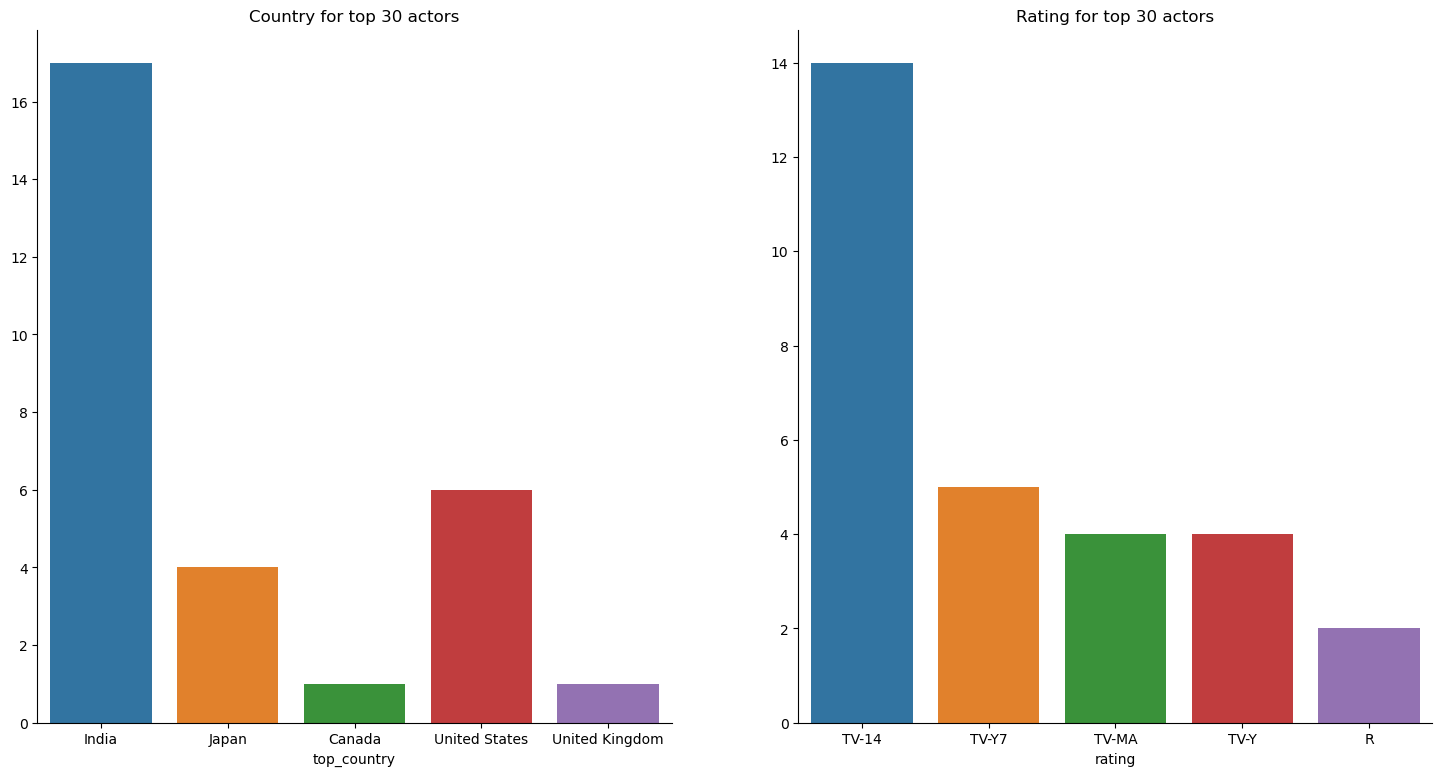

In [29]:
# Ploting rating and country of the market the top 30 actors have the most work
fig, axs = plt.subplots(1,2, figsize=(18,9))

sns.countplot(ax=axs[0], data=pd.DataFrame(details_dict).T, x='top_country')
axs[0].set_title('Country for top 30 actors')
axs[0].set(ylabel=None)
sns.countplot(ax=axs[1], data=pd.DataFrame(details_dict).T, x='rating')
axs[1].set_title('Rating for top 30 actors')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

**Insights on top 30 actors**
***
Exploring this particular case we can see that the top 30 actors operating in the indian market are far more than all the others alone, and other remarkable fact is that PG-14 is by far the denser category, while the others have somewhat the same volume appart from R rating that's the least represented.